# Варіант №5
## Класифікація зображень. Застосування нейромереж для пошуку подібних зображень.

Мета - набути практичних навиків у розв’язанні задачі пошуку подібних зображень на прикладі організації CNN класифікації.

### Завдання
Побудувати CNN на основі Inception-v3 для класифікації зображень на основі датасету fashion-mnist. Зробити налаштування моделі для досягнення необхідної точності. На базі Siamese networks побудувати систему для пошуку подібних зображень в датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

In [2]:
# !pip install tensorflow

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2023-04-12 20:13:30.000768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [13]:
# Using batching can help speed up the training process by allowing the model to process smaller chunks of data at a time, which can be more memory-efficient and reduce the time required for each weight update. It can also help generalize the model better by preventing it from overfitting to the training data.

In [14]:
# normalize the data
x_train = x_train.astype("float32") / 255.0  # [:10_000]
x_test = x_test.astype("float32") / 255.0

# reshape the data to 4D tensors
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [15]:
x_train.shape

(60000, 28, 28, 1)

In [16]:
print("Training", x_train.shape, x_train.max())
print("Testing", x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [17]:
def inception_v3(input_tensor):
    conv1 = Conv2D(32, (1, 1), activation="relu")(input_tensor)
    conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(input_tensor)
    conv3 = Conv2D(32, (5, 5), activation="relu", padding="same")(input_tensor)
    pool1 = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(input_tensor)
    concat1 = concatenate([conv1, conv2, conv3, pool1], axis=-1)

    conv4 = Conv2D(64, (1, 1), activation="relu")(concat1)
    conv5 = Conv2D(64, (3, 3), activation="relu", padding="same")(concat1)
    conv6 = Conv2D(64, (5, 5), activation="relu", padding="same")(concat1)
    pool2 = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(concat1)
    concat2 = concatenate([conv4, conv5, conv6, pool2], axis=-1)

    conv7 = Conv2D(128, (1, 1), activation="relu")(concat2)
    conv8 = Conv2D(128, (3, 3), activation="relu", padding="same")(concat2)
    conv9 = Conv2D(128, (5, 5), activation="relu", padding="same")(concat2)
    pool3 = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(concat2)
    concat3 = concatenate([conv7, conv8, conv9, pool3], axis=-1)

    # flatten and add fully connected layers
    flatten = Flatten()(concat3)
    dense1 = Dense(512, activation="relu")(flatten)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(10, activation="softmax")(dropout1)

    return dense2

In [18]:
input_shape = x_train.shape[1:]

# define input tensor
inputs = Input(shape=input_shape)

In [19]:
# build model
outputs = inception_v3(inputs)
model = Model(inputs, outputs)

In [20]:
# compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   64          ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   832         ['input_2[0][0]']                
                                                                                              

In [21]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model"s weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
batch_size = 128
epochs = 10
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback],
    verbose=1,
)

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8308
Epoch 1: saving model to training_1/cp.ckpt
469/469 [==============================] - 2596s 6s/step - loss: 0.4725 - accuracy: 0.8308 - val_loss: 0.3367 - val_accuracy: 0.8772
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8723
Epoch 2: saving model to training_1/cp.ckpt
469/469 [==============================] - 2624s 6s/step - loss: 0.3560 - accuracy: 0.8723 - val_loss: 0.2997 - val_accuracy: 0.8926
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8876
Epoch 3: saving model to training_1/cp.ckpt
469/469 [==============================] - 2578s 5s/step - loss: 0.3057 - accuracy: 0.8876 - val_loss: 0.2595 - val_accuracy: 0.9071
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8978
Epoch 4: saving model to training_1/cp.ckpt
469/469 [==============================] 

In [27]:
model.save("../saved_model/inception_v3.h5")

### Load

In [22]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp.ckpt'

In [23]:
model.load_weights(latest)

In [24]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [35]:
# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 243s - loss: 0.2277 - accuracy: 0.9250 - 243s/epoch - 775ms/step
Restored model, accuracy: 92.50%


In [47]:
# plt.figure(figsize=(14, 6))
# plt.plot(model.history["accuracy"])
# plt.plot(model.history["val_accuracy"])
# plt.title("Accuracy of InceptionV3 model")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.grid()
# plt.legend(["training_accuracy", "validation_accuracy"], loc="upper left")
# plt.show()

In [40]:
# plt.figure(figsize=(14, 6))
# plt.plot(model.history["loss"])
# plt.plot(model.history["val_loss"])
# plt.title("Model loss")
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.grid()
# plt.legend(["Training_loss", "validation_loss"], loc="upper left")
# plt.show()

In [36]:
preds = model.predict(x_test)

313/313 [==============================] - 236s 750ms/step


In [37]:
classes = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

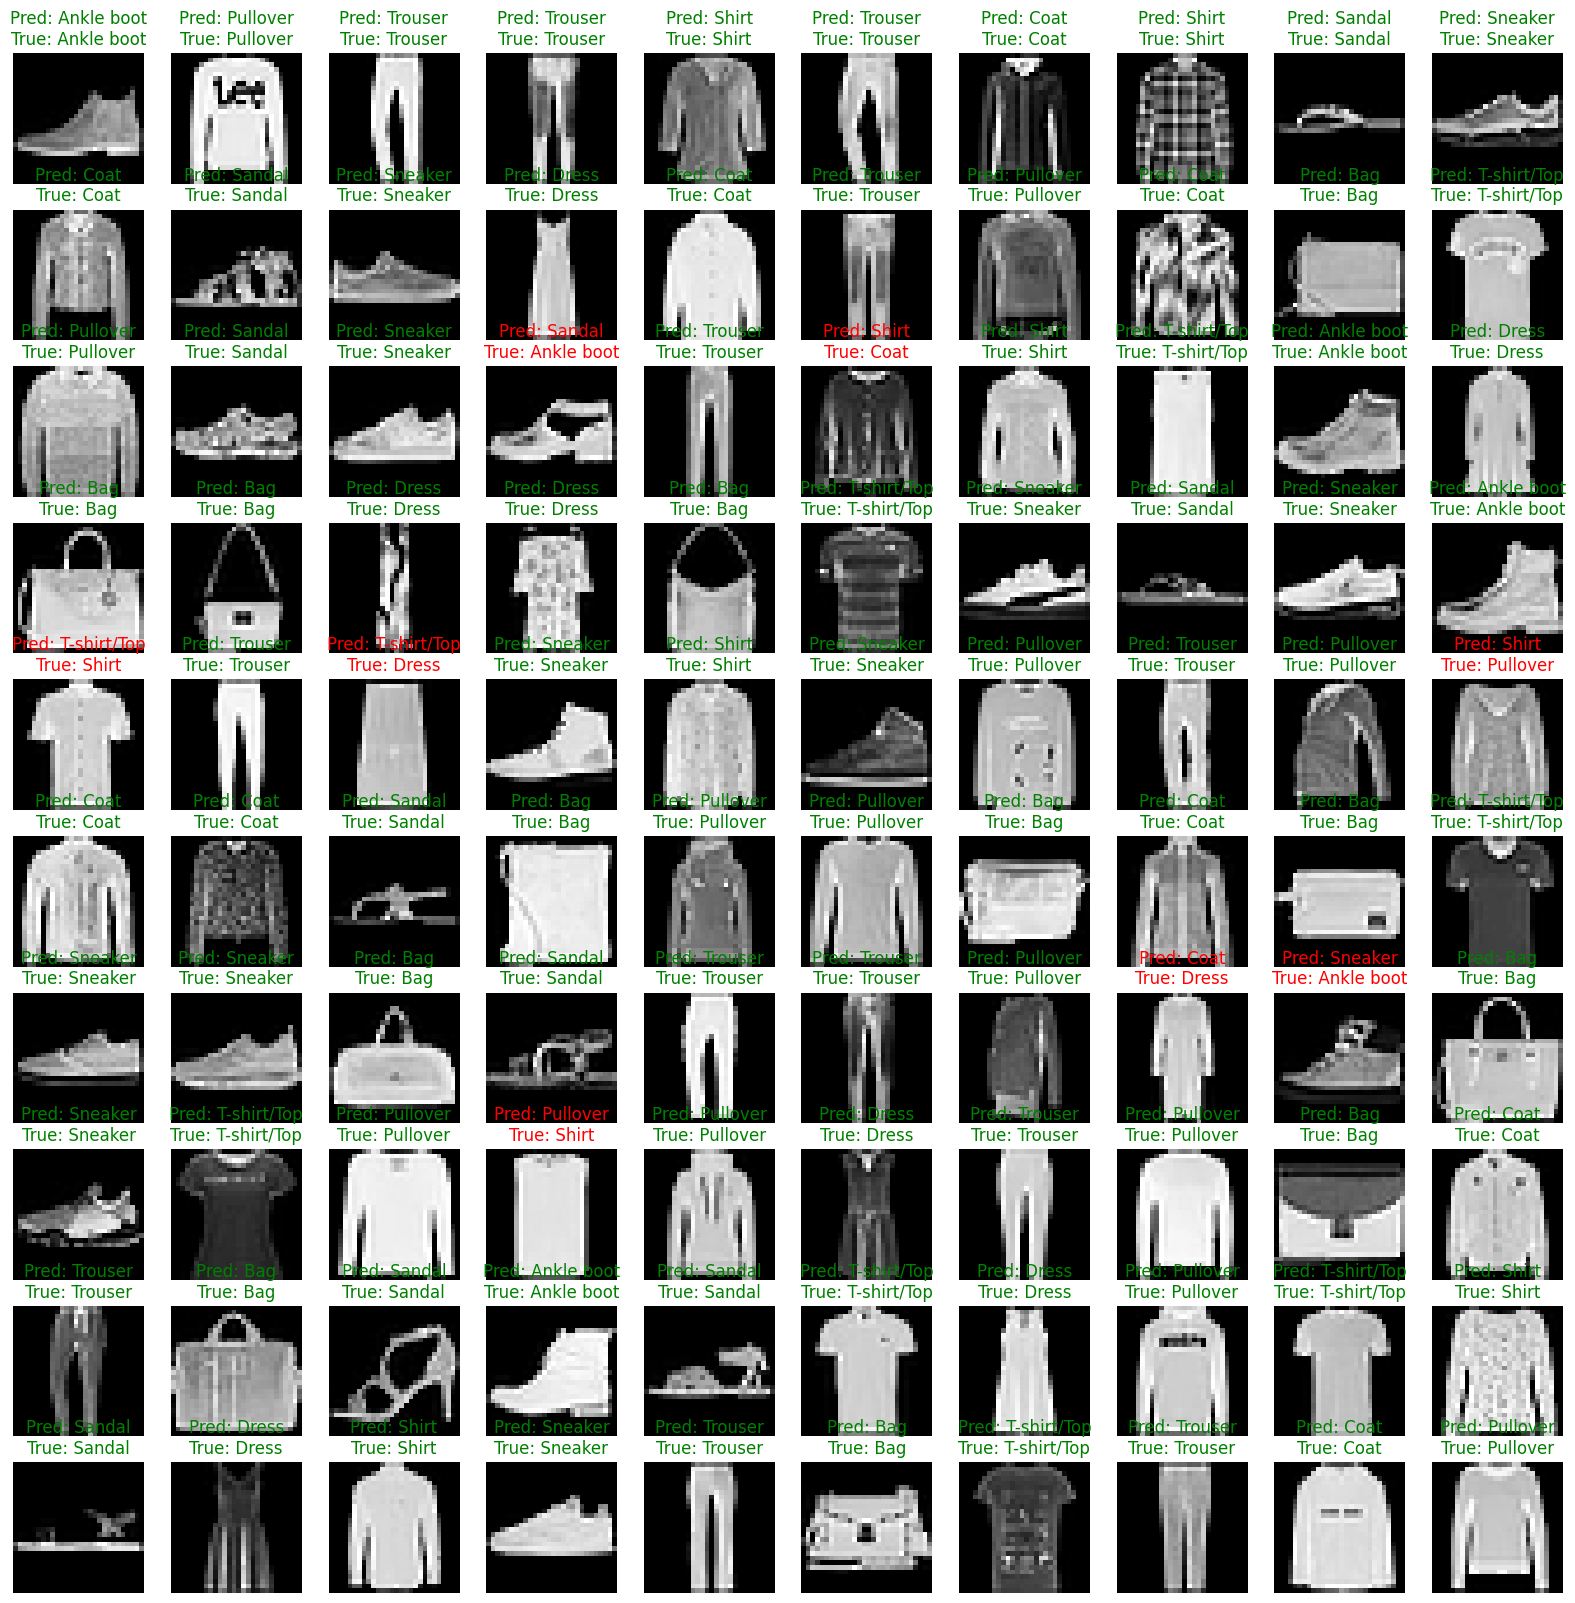

In [26]:
y_pred = np.argmax(preds, axis=1)
correct_preds = np.equal(y_pred, y_test)

num_display = 100
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))

for i in range(num_display):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax[row_idx][col_idx].imshow(x_test[i], cmap="gray")
    ax[row_idx][col_idx].axis("off")
    color = "green" if correct_preds[i] else "red"
    # ax[row_idx][col_idx].set_title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}", color=color)
    ax[row_idx][col_idx].set_title(f"Pred: {classes[y_pred[i]]}\nTrue: {classes[y_test[i]]}", color=color)

plt.show()

# Siamese

In [25]:
from keras.layers import concatenate, BatchNormalization, Activation

img_a_in = Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = Input(shape=x_train.shape[1:], name="ImageB_Input")

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = Dense(16, activation="linear")(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation("relu")(combined_features)
combined_features = Dense(4, activation="linear")(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation("relu")(combined_features)
combined_features = Dense(1, activation="sigmoid")(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name="Similarity_Model")

similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           271667018   ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['model[0][0]',   

In [38]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

In [33]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx]
                      [np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [34]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [35]:
print("train groups:", [x.shape[0] for x in train_groups])
print("test groups:", [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


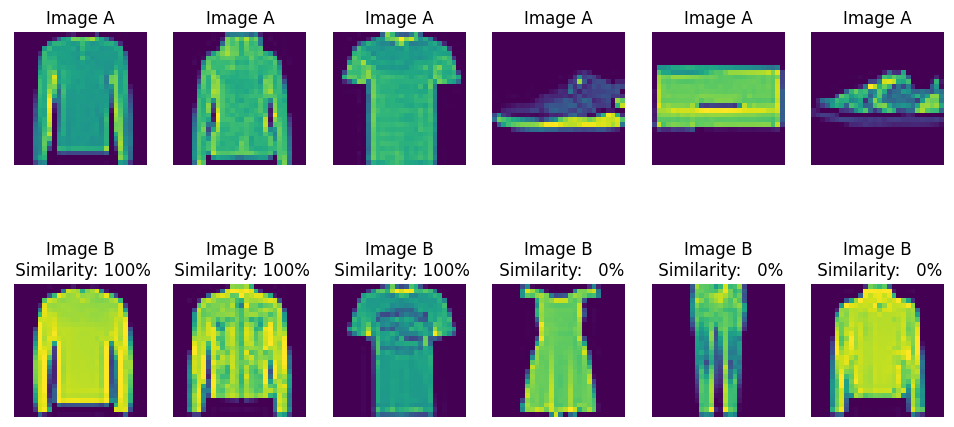

In [23]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title("Image A")
    ax1.axis("off")
    ax2.imshow(c_b[:,:,0])
    ax2.set_title("Image B\n Similarity: %3.0f%%" % (100*c_d))
    ax2.axis("off")

1/1 [==============================] - 1s 576ms/step


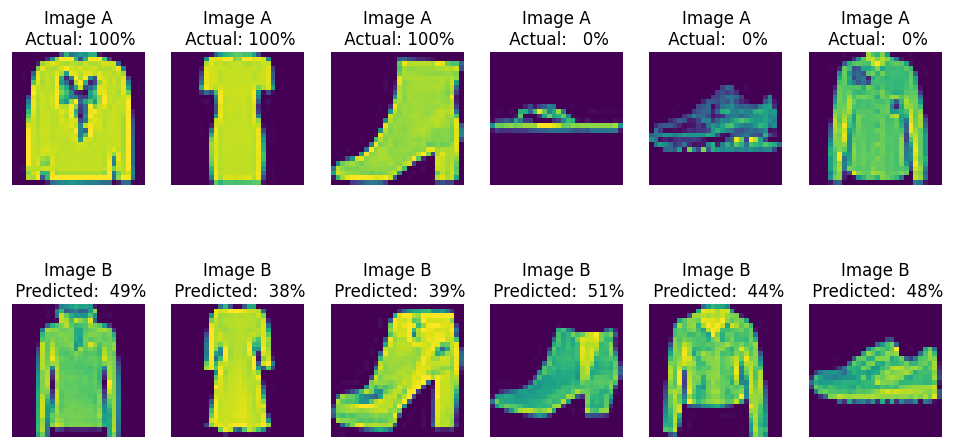

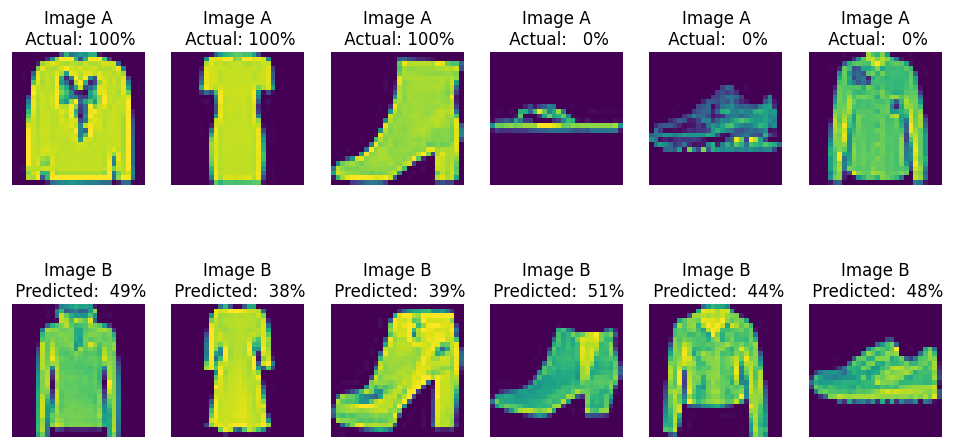

In [24]:
def show_sim_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
                                              m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


# a completely untrained model
show_sim_model_output()

In [2]:
sim_checkpoint_path = "training_2/cp.ckpt"
sim_checkpoint_dir = os.path.dirname(sim_checkpoint_path)

sim_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=sim_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [29]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                                              steps_per_epoch=500,
                                              validation_data=([valid_a, valid_b],
                                                               valid_sim),
    callbacks=[sim_cp_callback],
                                              epochs=8,
                                              verbose=True)

Epoch 1/8


2023-04-11 22:39:55.365323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.6638 - mae: 0.4674
Epoch 1: saving model to training_2/cp.ckpt
500/500 [==============================] - 2124s 4s/step - loss: 0.6638 - mae: 0.4674 - val_loss: 0.5701 - val_mae: 0.3910
Epoch 2/8
500/500 [==============================] - ETA: 0s - loss: 0.6885 - mae: 0.4911
Epoch 2: saving model to training_2/cp.ckpt
500/500 [==============================] - 2131s 4s/step - loss: 0.6885 - mae: 0.4911 - val_loss: 0.7248 - val_mae: 0.5000
Epoch 3/8
500/500 [==============================] - ETA: 0s - loss: 0.6931 - mae: 0.5000
Epoch 3: saving model to training_2/cp.ckpt
500/500 [==============================] - 2139s 4s/step - loss: 0.6931 - mae: 0.5000 - val_loss: 0.7010 - val_mae: 0.5000
Epoch 4/8
500/500 [==============================] - ETA: 0s - loss: 0.6931 - mae: 0.5000
Epoch 4: saving model to training_2/cp.ckpt
500/500 [==============================] - 2111s 4s/step - loss: 0.6931 - mae: 0.5000 - val_loss: 0.6957 

In [25]:
loss_history

NameError: name 'loss_history' is not defined

In [ ]:
# similarity_model.save("saved_model/sim_model.h5")

In [30]:
latest_sim = tf.train.latest_checkpoint(sim_checkpoint_dir)
latest_sim

'training_2/cp.ckpt'

In [31]:
similarity_model.load_weights(latest_sim)

In [30]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

1/1 [==============================] - 1s 502ms/step


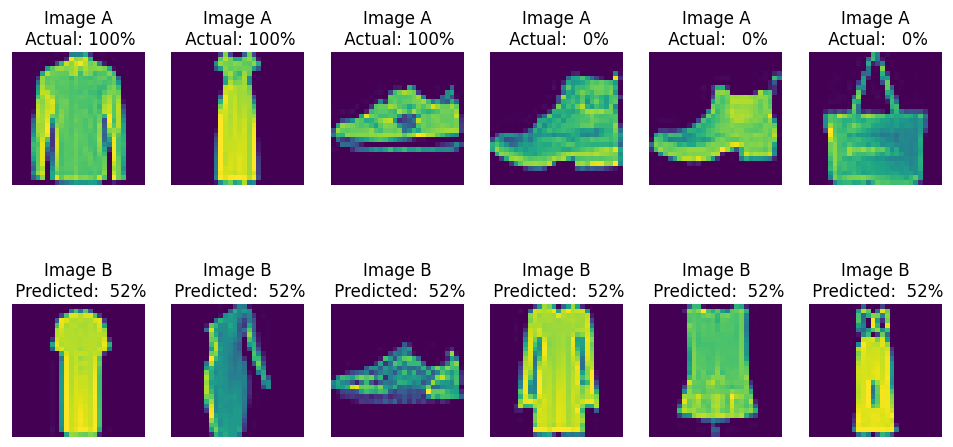

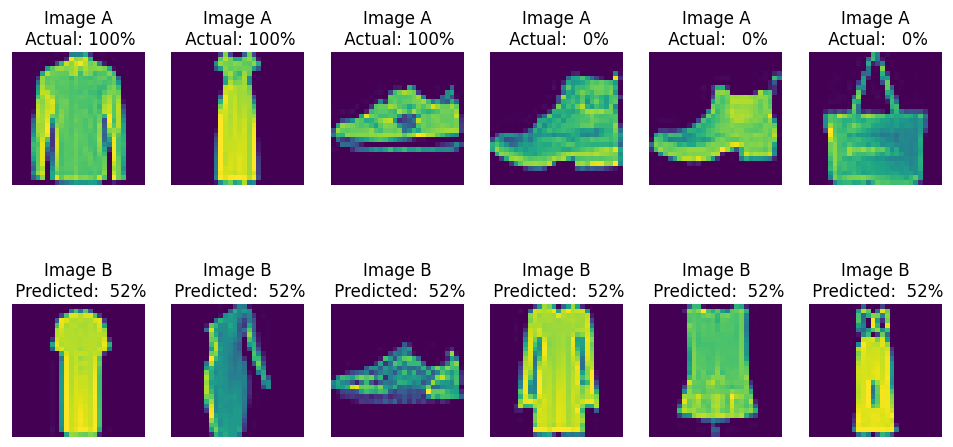

In [31]:
show_sim_model_output()

# TSNE

In [46]:
from sklearn.manifold import TSNE

In [47]:
x_test_features = model.predict(x_test, verbose=True, batch_size=128)

79/79 [==============================] - 219s 3s/step


In [57]:
# reduce the dimensionality of a set of features extracted from some input data
# down to 2 dimensions so that it can be visualized more easily
tsne_obj = TSNE(n_components=2,
                init="pca",
                random_state=101,
                method="barnes_hut",
                n_iter=500,
                verbose=1)

# fit the t-SNE model to the input data and generate the 2-dimensional output features
# can be plotted to visualize the distribution of the input data in a 2D space,
# which can be useful for clustering or classification tasks
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 2.798s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.719376
[t-SNE] KL divergence after 500 iterations: -0.034947


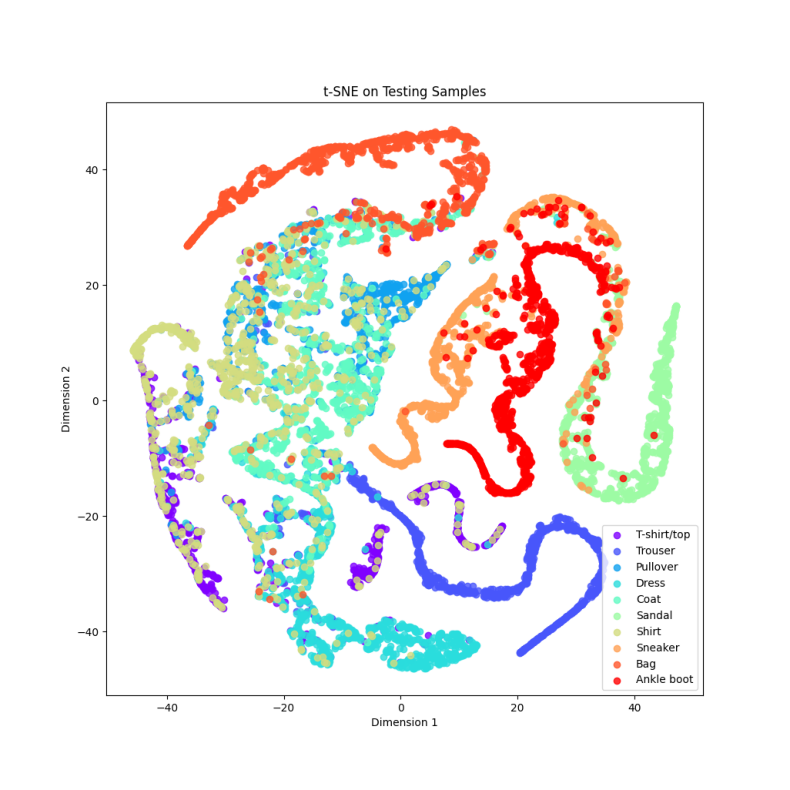

In [66]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, classes)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
plt.savefig("clothes-dist.png")
plt.show(block=False)

In [59]:
# print(tsne_features)